<a href="https://colab.research.google.com/github/MercyMoparthy/CNN-Project/blob/main/Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 4 with ResNet50V2 CNN Model

*   Loading ResNet50V2 model from Keras
*   images with 32*32 size and Optimizer as Adam
*   Data Augementation with Zoom Range as 0.5
*   Using ResNet50V2, with Density 32 and dropout as 0.5
*   Metrics Included Accuracy, F1 Score, Recall and Precise
*   Added Confusion Matrix


## Importing Data

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, datasets, utils, optimizers, callbacks, Input
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [3]:

# Check if CUDA is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading and Processing

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Resize images to the input shape expected by ResNet50 (224, 224)
IMG_HEIGHT, IMG_WIDTH = 32, 32
x_train = tf.image.resize(x_train, (IMG_HEIGHT, IMG_WIDTH)).numpy()
x_test = tf.image.resize(x_test, (IMG_HEIGHT, IMG_WIDTH)).numpy()
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
print("X Train:", x_train.shape)
print("Y Train:", y_train.shape)
print("X Test:", x_test.shape)
print("Y Test:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X Train: (50000, 32, 32, 3)
Y Train: (50000, 10)
X Test: (10000, 32, 32, 3)
Y Test: (10000, 10)


## Sample Data

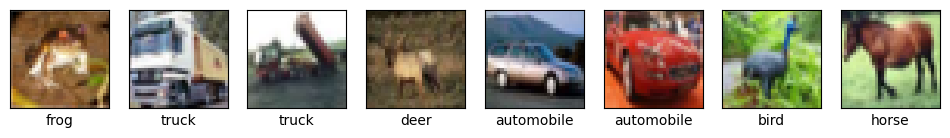

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=8):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # Labels are arrays like [[6]], so extract integer
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

# Call the function to plot
plot_sample_images(train_images, train_labels, class_names)

## Data Augmentation

In [6]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    zoom_range=0.5
)
datagen.fit(x_train)

## ResNet Model Architectire

In [15]:
from tensorflow.keras import regularizers
num_classes = 10
input_shape = (32, 32, 3)

# Load ResNet50 base (without the top classification head)
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = True  # Freeze the base model

# Build new model on top of ResNet50 base
model = models.Sequential([
    Input(shape=input_shape),
    layers.GaussianNoise(0.1),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


## Compile the Model

In [16]:
for layer in base_model.layers:  # adjust number based on experimentation
    layer.trainable = True
# Compile
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_2                │ (None, 32, 32, 3)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 1, 1, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,698 (90.14 MB)

 Trainable params: 23,585,258 (89.97 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Model Callbacks

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=2)

## Train the ResNet Model

In [18]:
from sklearn.model_selection import train_test_split
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

# Train using datagen on x_train_new
history = model.fit(
    datagen.flow(x_train_new, y_train_new, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.1031 - loss: 2.4776 - val_accuracy: 0.1626 - val_loss: 2.3435 - learning_rate: 5.0000e-05
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.1509 - loss: 2.3115 - val_accuracy: 0.2830 - val_loss: 2.1519 - learning_rate: 5.0000e-05
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.2194 - loss: 2.1835 - val_accuracy: 0.3670 - val_loss: 1.8831 - learning_rate: 5.0000e-05
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.2719 - loss: 2.0584 - val_accuracy: 0.4402 - val_loss: 1.6791 - learning_rate: 5.0000e-05
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.3099 - loss: 1.9668 - val_accuracy: 0.4924 - val_loss: 1.5246 - learning_rate: 5.0000e-05
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.3456 - loss: 1.8854 - val_accuracy: 0.5138 - val_loss: 1.4578 - learning_rate: 5.0000e-05
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/st

## Evaluate the ResNet Model

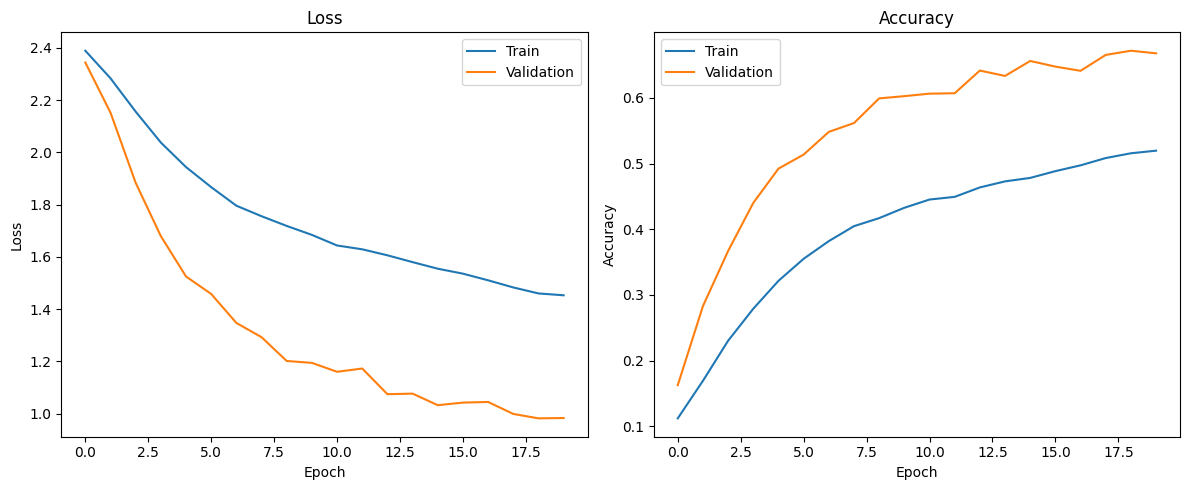

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Sample Visualization with Predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
              precision    recall  f1-score   support

    airplane       0.60      0.77      0.67      1000
  automobile       0.66      0.90      0.76      1000
        bird       0.61      0.51      0.55      1000
         cat       0.52      0.52      0.52      1000
        deer       0.81      0.39      0.53      1000
         dog       0.61      0.60      0.61      1000
        frog       0.70      0.73      0.72      1000
       horse       0.69      0.77      0.73      1000
        ship       0.86      0.70      0.77      1000
       truck       0.73      0.79      0.76      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.66     10000
weighted avg       0.68      0.67      0.66     10000



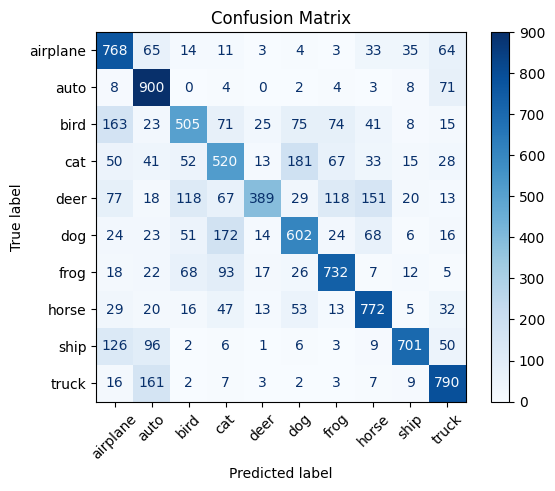

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot encoding back to integer labels
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=[
    'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'
]))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'airplane','auto','bird','cat','deer','dog','frog','horse','ship','truck'
])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9861791133880615
Test accuracy: 0.667900025844574
